In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
import os
import imghdr
from PIL import Image, UnidentifiedImageError

from tensorflow import keras as tfkeras
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-02-01 16:59:20.811265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 16:59:20.811326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 16:59:20.812924: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Import files/directories
Male = os.listdir('/kaggle/input/male-and-female-faces-dataset/Male and Female face dataset/Male Faces')
Female = os.listdir('/kaggle/input/male-and-female-faces-dataset/Male and Female face dataset/Female Faces')

print('Complete')
# masked = os.listdir('/kaggle/input/mask-or-nomask-data/fully_covered')
# unmasked = os.listdir('/kaggle/input/mask-or-nomask-data/not_covered')

Complete


In [3]:
# Data

x = []
y = []

height, width = 155, 155

for file in Male:
    try:
        img = Image.open('/kaggle/input/male-and-female-faces-dataset/Male and Female face dataset/Male Faces/' + file).convert('RGB')
        img = img.resize((height, width))
        x.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass

for file in Female:
    try:
        img = Image.open('/kaggle/input/male-and-female-faces-dataset/Male and Female face dataset/Female Faces/' + file).convert('RGB')
        img = img.resize((height, width))
        x.append(np.asarray(img))
        y.append(0)
    except UnidentifiedImageError:
        pass


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
# Convert to NumPy array
x = np.asarray(x)
y = np.asarray(y)

print(x.shape, y.shape)

x = x.astype('float32')
x /= 255

print(x.shape, y.shape)

(5418, 155, 155, 3) (5418,)
(5418, 155, 155, 3) (5418,)


In [5]:
# Split data into train, test and validation
classes = 2

labels = tfkeras.utils.to_categorical(y, classes)
print(f'labels: {labels[0]}')

x_training, x_test, y_training, y_test = train_test_split(x, labels, test_size=0.3, random_state=17)

x_train, x_val, y_train, y_valid  = train_test_split(x_training, y_training, test_size=0.3, random_state=17)

print(f'''
    Train images: {len(x_train)},
    Validation set: {len(x_val)},
    Test data: {len(x_test)}
''')

labels: [0. 1.]

    Train images: 2654,
    Validation set: 1138,
    Test data: 1626



In [8]:
# Initialize model(s)

pretrained_base = tfkeras.applications.InceptionV3(
    input_shape=(155, 155, 3),
    include_top=False,
    weights='imagenet'
)

for layer in pretrained_base.layers[:-10]:
    layer.trainable=False

# Complete model 

image_model = tfkeras.models.Sequential([
    pretrained_base,
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])

image_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 dropout_2 (Dropout)         (None, 3, 3, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               2359424   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_189 (B  (None, 128)               512       
 atchNormalization)                                              
                                                      

In [10]:
# Metrics 
metrics = [ 
    tfkeras.metrics.CategoricalAccuracy(name='accuracy'),
    tfkeras.metrics.Precision(name='precision'),
    tfkeras.metrics.Recall(name='recall'),
    tfkeras.metrics.AUC(name='AUC')
]

# Callbacks
early_stop = tfkeras.callbacks.EarlyStopping(
    patience=7,
    verbose=1
)

# Compile and fit model
image_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

history = image_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_valid),
    epochs=50,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50


2024-02-01 17:06:13.984076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


83/83 [==============================] - 13s 87ms/step - loss: 0.0375 - accuracy: 0.9872 - precision: 0.9872 - recall: 0.9872 - AUC: 0.9988 - val_loss: 0.0653 - val_accuracy: 0.9807 - val_precision: 0.9807 - val_recall: 0.9807 - val_AUC: 0.9947
Epoch 2/50
83/83 [==============================] - 5s 55ms/step - loss: 0.0280 - accuracy: 0.9910 - precision: 0.9910 - recall: 0.9910 - AUC: 0.9992 - val_loss: 0.0616 - val_accuracy: 0.9807 - val_precision: 0.9807 - val_recall: 0.9807 - val_AUC: 0.9976
Epoch 3/50
83/83 [==============================] - 5s 55ms/step - loss: 0.0325 - accuracy: 0.9879 - precision: 0.9879 - recall: 0.9879 - AUC: 0.9991 - val_loss: 0.0929 - val_accuracy: 0.9754 - val_precision: 0.9754 - val_recall: 0.9754 - val_AUC: 0.9952
Epoch 4/50
83/83 [==============================] - 4s 54ms/step - loss: 0.0192 - accuracy: 0.9943 - precision: 0.9943 - recall: 0.9943 - AUC: 0.9998 - val_loss: 0.1229 - val_accuracy: 0.9780 - val_precision: 0.9780 - val_recall: 0.9780 - val_AU

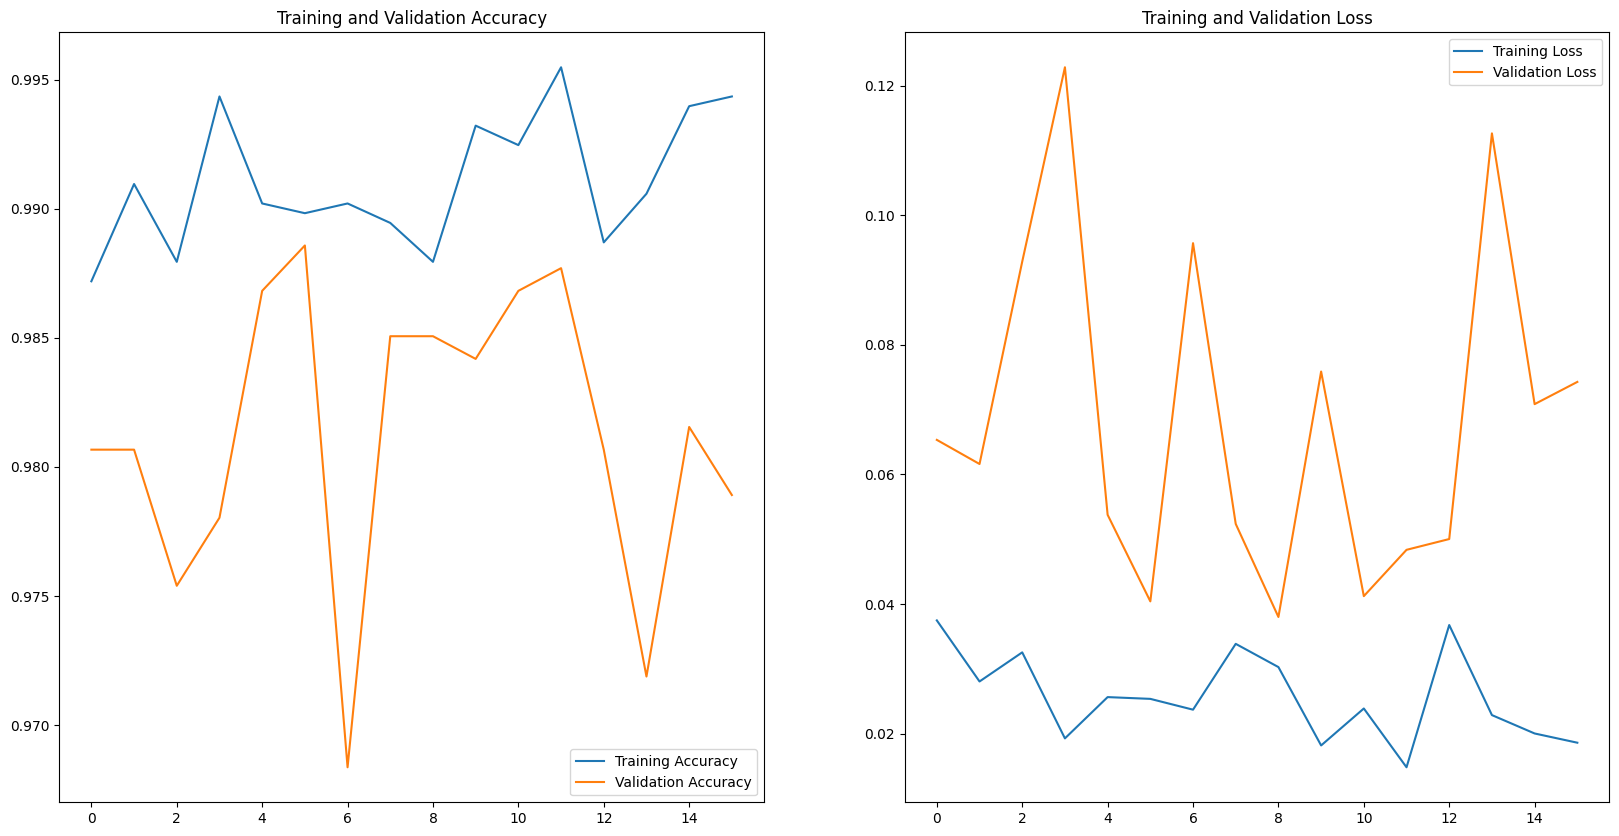

In [11]:
# Plot values for accuracy and loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# Evaluate model
results = image_model.evaluate(x_test, y_test, batch_size=32)

print(f'Your model has an accuracy of {100*results[1]} %')

51/51 [==============================] - 4s 77ms/step - loss: 0.0556 - accuracy: 0.9871 - precision: 0.9871 - recall: 0.9871 - AUC: 0.9936
Your model has an accuracy of 98.70848655700684 %


In [16]:
# Image preprocessing and prediction
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

def process_image(imagefile):
    img = image.load_img(imagefile, target_size=(155, 155))
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    # Add an extra dimension to the array (for batch size)
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the image (normalize pixel values)
    processed_image = preprocess_input(img_array)
    return processed_image

img_file = '/kaggle/input/test-images/tonia.jpg'
image = process_image(img_file)
masked_classes = {
    0: 'Female',
    1: 'Male'
}

prediction = image_model.predict(image)

prediction_class = np.argmax(prediction)
certainty = 100 * np.max(prediction)

print(f'Input image: {img_file}')
print(f'Predicted: {masked_classes[prediction_class]}')
print(f'Certainty: {certainty:.2f}%')

1/1 [==============================] - 0s 33ms/step
Input image: /kaggle/input/test-images/tonia.jpg
Predicted: Male
Certainty: 99.56%
